In [1]:
using Pkg; Pkg.activate(".")

  Activating project at `~/Downloads/scratch`


In [2]:
using LinearAlgebra
using Random
using Distributions
using ForwardDiff

using Plots

$$
\newcommand{\N}{\mathcal{N}}
\renewcommand{\vec}[1]{\boldsymbol{#1}}          % vector
\newcommand{\mat}[1]{\boldsymbol{#1}}  
\newcommand{\g}{\mid}
$$

## Build the state-space model
for states and measurements
$$
\vec{x}_k = \begin{pmatrix}u_k \\ v_k\end{pmatrix}\in \mathbb{R}^D \qquad \vec{y}_k = \begin{pmatrix}\hat{u}_k\\\hat{v}_k\end{pmatrix}\in \mathbb{R}^d \qquad k = 1, \dots, T
$$

In [3]:
d, D = 2, 2;

### Initial distribution

$$\boldsymbol{x}_0 \sim \N(\vec{\mu}_0, \mat{\Sigma}_0)$$
with
$$
\begin{align}
\vec\mu_0 &= \left[-1 ~~ 1\right]^\top\\
\mat\Sigma_0 &= \begin{pmatrix}1.0 & 0.0 \\ 0.0 & 1.0\end{pmatrix}
\end{align}
$$

In [4]:
μ₀ = [-1.0, 1.0]
Σ₀ = [0.01 0.0
      0.0 0.01];

### Dynamics
$$\boldsymbol{x}_k \mid \boldsymbol{x}_{k-1} \sim \N(f(\vec{x}_{k-1}), \mat{Q}_{k-1})$$
with
$$
\begin{align}
f(\vec{x}_k) = f\left(\begin{pmatrix}u_k \\ v_k\end{pmatrix}\right) &= 
\begin{pmatrix}
 u_k + 0.1 \cdot (c \cdot (u_k - u_k^3 / 3 + v_k))\\
 v_k + 0.1 \cdot (-(1 / c) \cdot (u_k - a - b \cdot v_k))
\end{pmatrix}\\[2mm]
    \mat{Q}_k = \mat{Q} &=
    \begin{pmatrix}
        0.01 &  0.0\\
         0.0 & 0.01
    \end{pmatrix}
\end{align}
$$
and
$$
\begin{align}
    a &= 0.2 \\
    b &= 0.2 \\
    c &= 3.0
\end{align}
$$

In [5]:
a, b, c = 0.2, 0.2, 3.0

function f(x)
    u, v = x
    return [
        u + 0.1 * (c * (u - u^3 / 3 + v)),
        v + 0.1 * (-(1 / c) * (u - a - b * v))
    ]

end

Q = Matrix(0.001 * I(D))

2×2 Matrix{Float64}:
 0.001  0.0
 0.0    0.001

### Measurement model

$$\boldsymbol{y}_k \mid \boldsymbol{x}_k \sim \N(h(\vec{x}_k), \mat{R}_k)$$
with
$$
\begin{align}
h(\vec{x}_k) = \vec{x}_k\\[2mm]
    \mat{R}_k = \begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix}
\end{align}
$$

In [6]:
function h(x)
    return copy(x)
end

R = [1.0 0.0
      0.0 1.0];

## Simulate a trajectory and draw noisy observations

In [7]:
function simulate_nonlinear(
    f::Function,
    Q,
    h::Function,
    R,
    μ₀,
    Σ₀,
    N::Int;
    rng = Random.GLOBAL_RNG,
)
    x = rand(rng, MvNormal(μ₀, Σ₀))
    states = [x]
    observations = []

    for i in 1:N
        push!(states, rand(rng, MvNormal(f(states[end]), Q)))
        push!(observations, rand(rng, MvNormal(h(states[end]), R)))
    end
    return states, observations
end

simulate_nonlinear (generic function with 1 method)

In [8]:
N = 200

200

In [9]:
ground_truth, observations = simulate_nonlinear(f, Q, h, R, μ₀, Σ₀, N);
state_idcs = 1:length(ground_truth)
data_idcs = 2:length(observations)+1

2:201

In [10]:
T = 1:N+1

1:201

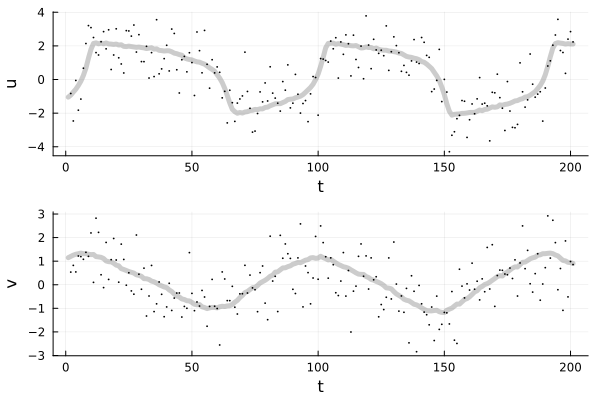

In [11]:
t1 = plot(
   state_idcs,
    [y[1] for y in ground_truth];
    xlabel="t",
    ylabel="u",
    color=:gray,
    lw=5,
    alpha=0.4,
    legend=false
)
scatter!(data_idcs, [y[1] for y in observations]; color=:black, markersize=1)
t2 = plot(
    state_idcs,
    [y[2] for y in ground_truth];
    xlabel="t",
    ylabel="v",
    color=:gray,
    lw=5,
    alpha=0.4,
    legend=false
)
scatter!(data_idcs, [y[2] for y in observations]; color=:black, markersize=1)
plot(t1, t2, layout=(2,1))

## Filtering — The extended Kalman Filter

### Prediction
$$
\begin{align}
      \vec{\mu}^- & = f(\vec{\mu}_{k-1}) \\
      \mat{\Sigma}^- &= \mat{J}_f(\vec{\mu}_{k-1})\mat{\Sigma}_{k-1}\mat{J}_f(\vec{\mu}_{k-1})^\top + \mat{Q}_{k-1}
\end{align}
$$

In [12]:
function ekf_predict(μ, Σ, f, Q)
    μ⁻ = f(μ)
    Jf = ForwardDiff.jacobian(f, μ)
    Σ⁻ = Jf * Σ * Jf' + Q
    return μ⁻, Σ⁻, Jf
end

ekf_predict (generic function with 1 method)

### Correction
$$
\begin{align}
  \hat{\vec{y}}_k &= h(\vec{\mu}^-_k) \\
  \mat{S}_k &= {\mat{J}_h(\vec{\mu}_k^-)}\mat{\Sigma}^-_k{\mat{J}_h(\vec{\mu}_k^-)^\top} + \mat{R}_k \\
  \mat{K}_k &= \mat{\Sigma}^-_k{\mat{J}_h(\vec{\mu}_k^-)^\top}\mat{S}^{-1}_k \\
  \vec{\mu}_k &= \vec{\mu}^-_k + \mat{K}_k (\vec{y}_k - \hat{\vec{y}}_k)\\
  \mat{\Sigma}_k &= \mat{\Sigma}^-_k - \mat{K}_k\mat{S}_k\mat{K}_k^\top
\end{align}
$$

In [13]:
function ekf_correct(μ⁻, Σ⁻, h, R, y)
    Jh = ForwardDiff.jacobian(h, μ⁻)
    y_hat = h(μ⁻)
    S = Jh * Σ⁻ * Jh' + R
    K = Σ⁻ * Jh' / Symmetric(S)
    μ = μ⁻ + K * (y - y_hat)
    Σ = Σ⁻ - K * S * K'
    return μ, Σ
end

ekf_correct (generic function with 1 method)

### Backwards transitions

$$
\begin{align}
\mat{G}_{k} &= \mat{\Sigma}_{k}\mat{A}_{k}^\top \left[\mat{\Sigma}^-_{k+1}\right]^{-1} \\
            \vec{\xi}_k &= \vec{\mu}_k + \mat{G}_{k} \left(\vec{\xi}_{k+1} - \vec{\mu}^-_{k+1}\right)\\
                        &= \mat{G}_{k} \vec{\xi}_{k+1} + \underbrace{\vec{\mu}_k - \mat{G}_{k} \vec{\mu}^-_{k+1}}_{=: \vec{b}_k}\\
            \mat{\Lambda}_{k} &= \mat{\Sigma}_{k} + \mat{G}_{k}\left(\mat{\Lambda}_{k+1} - \mat{\Sigma}^-_{k+1}\right)\mat{G}_k^\top \\
                              &= \mat{G}_{k} \mat{\Lambda}_{k+1} \mat{G}_{k}^\top + \underbrace{\mat{\Sigma}_k - \mat{G}_{k}\mat{\Sigma}^-_{k+1}\mat{G}_{k}^\top}_{=: \mat{C}_k}
\end{align}
$$

$$
\begin{align}
            p(\vec{x}_k \g \vec{x}_{k+1}, \vec{y}_{1:T}) &= \N(\vec{x}_k; \mat{G}_{k}\vec{x}_{k+1} + \vec{b}_k, \mat{C}_k) \\
            \vec{b}_k &= \vec{\mu}_k - \mat{G}_{k} \vec{\mu}^-_{k+1} \\
            \mat{C}_k &= \mat{\Sigma}_k - \mat{G}_{k}\mat{\Sigma}^-_{k+1}\mat{G}_{k}^\top
  \end{align}
$$

In [14]:
function get_backward_transition(μ, Σ, μ⁻, Σ⁻, A)
    G = Σ * A' / Symmetric(Σ⁻)
    b = μ - G * μ⁻
    C = Σ - G * Σ⁻ * G'
    return G, b, C
end

get_backward_transition (generic function with 1 method)

In [15]:
filter_estimate = [(μ₀, Σ₀)]
predicted_moments = []
backwards_transitions = []
for k in data_idcs
    # start from last point
    μ, Σ = filter_estimate[end]
    # predict
    μ⁻, Σ⁻, Aₖ = ekf_predict(μ, Σ, f, Q)
    push!(predicted_moments, (μ⁻, Σ⁻))
    push!(backwards_transitions, get_backward_transition(μ, Σ, μ⁻, Σ⁻, Aₖ))
    push!(filter_estimate, ekf_correct(μ⁻, Σ⁻, h, R, observations[k-1]))
end

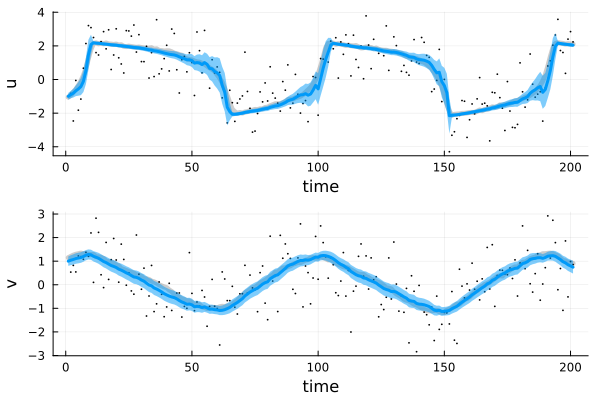

In [16]:
fp1 = plot!(deepcopy(t1),
    state_idcs, 
    [y[1] for (y, s) in filter_estimate];
    xlabel="time",
    ylabel="u",
    label="Filter Estimate",
    color=1,
    lw=3,
    ribbon=[2sqrt(s[1, 1]) for (y, s) in filter_estimate],
)
fp2 = plot!(deepcopy(t2),
    state_idcs, 
    [y[2] for (y, s) in filter_estimate];
    xlabel="time",
    ylabel="v",
    label="Filter Estimate",
    color=1,
    lw=3,
    ribbon=[2sqrt(s[2, 2]) for (y, s) in filter_estimate]
)
plot(fp1, fp2, layout=(2, 1))

## Smoothing — The Rauch-Tung-Striebel Smoother

$$
\begin{align}
\mat{G}_{k} &= \mat{\Sigma}_{k}\mat{J}_f(\vec{\mu}_k)^\top \left[\mat{\Sigma}^-_{k+1}\right]^{-1} \\
\vec{\xi}_k &= \vec{\mu}_k + \mat{G}_{k} \left(\vec{\xi}_{k+1} - \vec{\mu}^-_{k+1}\right)\\
\mat{\Lambda}_{k} &= \mat{\Sigma}_{k} + \mat{G}_{k}\left(\mat{\Lambda}_{k+1} - \mat{\Sigma}^-_{k+1}\right)\mat{G}_k^\top
\end{align}
$$

In [17]:
function ekf_smooth(μ, Σ, ξ_next, Λ_next, μ⁻, Σ⁻, f, Q)
    Jf = ForwardDiff.jacobian(f, μ)    
    G = Σ * Jf' / Symmetric(Σ⁻)
    ξ = μ + G * (ξ_next - μ⁻)
    Λ = Σ + G * (Λ_next - Σ⁻) * G'
    return ξ, Λ
end

ekf_smooth (generic function with 1 method)

In [18]:
smoother_estimate = [filter_estimate[end]]
for k in reverse(state_idcs[1:end-1])
    ξ_next, Λ_next = smoother_estimate[1]
    μ⁻, Σ⁻ = predicted_moments[k]
    μ, Σ = filter_estimate[k]
    pushfirst!(smoother_estimate, ekf_smooth(μ, Σ, ξ_next, Λ_next, μ⁻, Σ⁻, f, Q))
end

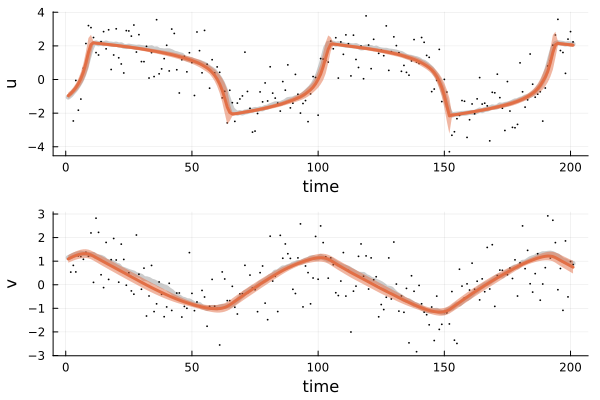

In [19]:
sp1 = plot!(deepcopy(t1),
    state_idcs, 
    [y[1] for (y, s) in smoother_estimate];
    xlabel="time",
    ylabel="u",
    label="Smoother Estimate",
    color=2,
    lw=3,
    ribbon=[2sqrt(s[1, 1]) for (y, s) in smoother_estimate],
)
sp2 = plot!(deepcopy(t2),
    state_idcs, 
    [y[2] for (y, s) in smoother_estimate];
    xlabel="time",
    ylabel="v",
    label="Smoother Estimate",
    color=2,
    lw=3,
    ribbon=[2sqrt(s[2, 2]) for (y, s) in smoother_estimate],
)
plot(sp1, sp2, layout=(2, 1))

In [20]:
backwards_predictions = [filter_estimate[end]]
for k in reverse(state_idcs[1:end-1])
    ξ_next, Λ_next = backwards_predictions[1]
    G, b, C = backwards_transitions[k]
    ξ, Λ, ignore = ekf_predict(ξ_next, Λ_next, x->G * x + b, C)
    pushfirst!(backwards_predictions, (ξ, Λ))
end

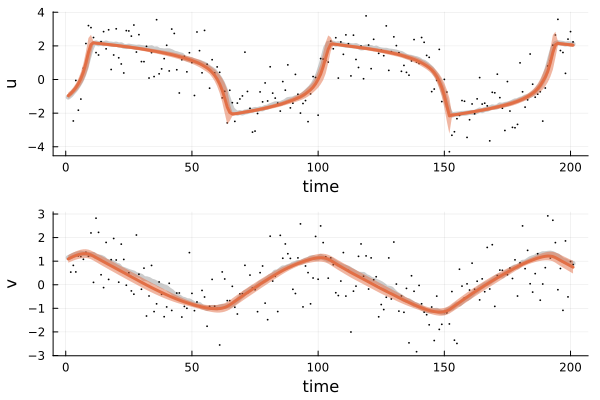

In [21]:
bp1 = plot!(deepcopy(t1),
    T, 
    [y[1] for (y, s) in backwards_predictions];
    xlabel="time",
    ylabel="u",
    label="Smoother Estimate",
    color=2,
    lw=3,
    ribbon=[2sqrt(s[1, 1]) for (y, s) in backwards_predictions],
)
bp2 = plot!(deepcopy(t2),
    T, 
    [y[2] for (y, s) in backwards_predictions];
    xlabel="time",
    ylabel="v",
    label="Smoother Estimate",
    color=2,
    lw=3,
    ribbon=[2sqrt(s[2, 2]) for (y, s) in backwards_predictions],
)
plot(bp1, bp2, layout=(2, 1))

In [22]:
for ((m1, C1), (m2, C2)) in zip(smoother_estimate, backwards_predictions)
    @assert m1 ≈ m2
    @assert C1 ≈ C2
end

## Drawing posterior samples!

In [23]:
posterior_samples = []
for is in 1:100
    x = rand(MvNormal(smoother_estimate[end][1], Symmetric(smoother_estimate[end][2])))
    sample_path = [x]
    for k in reverse(state_idcs[1:end-1])
        G, b, C = backwards_transitions[k]
        pushfirst!(sample_path, rand(MvNormal(G * sample_path[1] + b, Symmetric(C))))
    end
    push!(posterior_samples, deepcopy(sample_path))
end

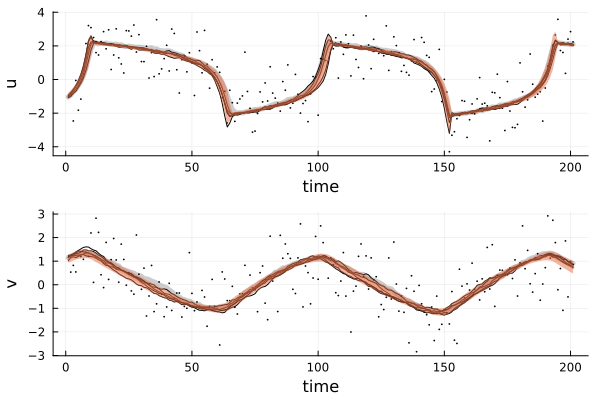

In [24]:
ssp1 = deepcopy(t1)
ssp2 = deepcopy(t2)

for smpl in posterior_samples[1:5]
    plot!(
        ssp1, 
        T,
        [y[1] for y in smpl];
        lw=1,
        color=:black,
    ) 
    plot!(
        ssp2, 
        T,
        [y[2] for y in smpl];
        lw=1,
        color=:black,
    ) 
end
plot!(ssp1,
    T, 
    [y[1] for (y, s) in backwards_predictions];
    xlabel="time",
    ylabel="u",
    label="Smoother Estimate",
    color=2,
    lw=3,
    alpha=0.3,
    ribbon=[2sqrt(s[1, 1]) for (y, s) in backwards_predictions],
)
plot!(ssp2,
    T, 
    [y[2] for (y, s) in backwards_predictions];
    xlabel="time",
    ylabel="v",
    label="Smoother Estimate",
    color=2,
    lw=3,
    alpha=0.3,
    ribbon=[2sqrt(s[2,2]) for (y, s) in backwards_predictions],
)
plot(ssp1, ssp2, layout=(2,1))

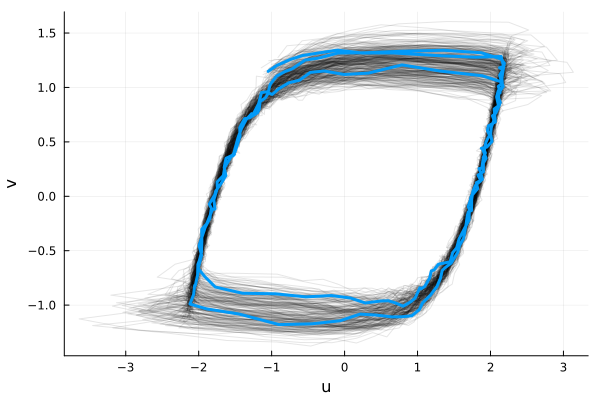

In [25]:
phase_plot = plot(
    [y[1] for y in ground_truth],
    [y[2] for y in ground_truth],
    legend=false,
    xlabel="u",
    ylabel="v"
)
for smpl in posterior_samples
    plot!(
        phase_plot, 
        [y[1] for y in smpl],
        [y[2] for y in smpl];
        lw=1,
        color=:black,
        label="",
        alpha=0.1
    ) 
end
plot!(phase_plot,
    [y[1] for y in ground_truth],
    [y[2] for y in ground_truth],
    legend=false,
    lw=3,
    color=1
)
plot(phase_plot)